# 2. 이미지 옮기기

In [1]:
import os
import shutil
import glob

train_folder = os.listdir('./train/')
print(len(train_folder))  # -폴더개수 88 , 사진개수 = 4277개
train_folder2 = os.listdir('./train2/')
print(len(train_folder2))

# train 2를 train1로

7
7


In [10]:
for i in range(len(train_folder2)):
    file_source2 = glob.glob(f'./train2/{train_folder2[i]}/*') # train2 폴더에 있는 해당 이미지를

    for j in range(len(file_source2)):

        file_source = file_source2[j]
        file_destination = f'./train/{train_folder2[i]}/' # 해당 폴더로 이동 

        file_path = file_destination + file_source[-9:]     

        if os.path.exists(file_path):                    #그 폴더에 이미 그 이름의 이미지가 있다면 
            os.remove(file_path)                         # 삭제 
        
        shutil.move(file_source, file_destination)  



# 이동 실행

Error: Destination path './train/bottle-broken_small/arumentation_1650245971.6157174.png' already exists

In [74]:
import shutil

for i in range(len(train_folder)):  # 폴더 생성한것 88개 뺴주는 겁니다.
    
    if train_folder[i][-3:] == "png":   # 확장자가 png면 
        label = train_df.loc[train_df["file_name"] == f"{train_folder[i]}"]["label"][i]  # train_df에서 이미지 이름에 맞는 label을 불러와 저장
        file_source = f'./train/{train_folder[i]}'  # train 폴더에 있는 해당 이미지를
        file_destination = f'./train/{label}/'  # 해당 label 폴더로 이동 
        shutil.move(file_source, file_destination)  # 이동 실행

- 실행결과 다음과 같이 폴더에 이미지가 정리됩니다

<br/>

![레이블 정렬된 모습](https://user-images.githubusercontent.com/87745990/162142370-fc08d879-7d21-4a9c-97bf-3d3402affc9c.png)

# 3. 이미지 전처리와 데이터 split 까지

In [75]:
import numpy as np
import torchvision.transforms as transforms
from torchvision import datasets

- 평균과 표준편차로 이미지 normalization 을 진행하기 위해 값을 구해봅니다

In [76]:
def get_mean_std(data_dir):
    '''
    이미지 정규화 시 성능 향상 , 평균과 표준편차로 정규화 실행
    data_dir = 이미지 들어있는 폴더 path
    '''
    transform = transforms.Compose([
        transforms.Resize((1024, 1024)),
        transforms.ToTensor()
    ])

    dataset = datasets.ImageFolder(os.path.join(f'./{data_dir}'), transform)
    print("데이터 정보", dataset)

    meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in dataset]
    stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in dataset]

    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])

    stdR = np.mean([s[0] for s in stdRGB])
    stdG = np.mean([s[1] for s in stdRGB])
    stdB = np.mean([s[2] for s in stdRGB])
    print("평균",meanR, meanG, meanB)
    print("표준편차",stdR, stdG, stdB)

# train data, test data 다르게 nomalization 적용하려면 data_dir 바꾸세요.
data_dir = "train"
get_mean_std(data_dir)



데이터 정보 Dataset ImageFolder
    Number of datapoints: 4277
    Root location: ./train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
평균 0.4330383 0.4034577 0.3941509
표준편차 0.18356353 0.1755653 0.16484421


In [82]:
# 1024x1024 resize train / meanR=0.43303847, meanG=0.4034577, meanB=0.39415097  / stdR=0.18344551, stdG=0.17549995, stdB=0.1647388   
# 128x128 resize train / meanR=0.43305725, meanG=0.40347522, meanB=0.3941705  / stdR=0.17281055, stdG=0.16584247, stdB=0.15571058 


from torch.utils.data.sampler import SubsetRandomSampler
import torch

data_dir = "./"

def create_datasets(batch_size):
    
    train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 좌우반전 
    transforms.RandomVerticalFlip(),  # 상하반전 
    transforms.Resize((1024, 1024)),  # 알맞게 변경하세요 
    transforms.ToTensor(),  # 이 과정에서 [0, 255]의 범위를 갖는 값들을 [0.0, 1.0]으로 정규화, torch.FloatTensor로 변환
    transforms.Normalize([0.43303847,0.4034577, 0.39415097], [0.18344551,0.17549995, 0.1647388])  #  정규화(normalization)
])
    test_transform = transforms.Compose([   # 나중에 test 데이터 불러올 때 참고하세요. 
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(), # 이 과정에서 [0, 255]의 범위를 갖는 값들을 [0.0, 1.0]으로 정규화 
    transforms.Normalize([0.43303847,0.4034577, 0.39415097], [0.18344551,0.17549995, 0.1647388])  # 테스트 데이터로 계산을 진행해서 따로 지정해주어도 좋습니다
])

    # choose the training and test datasets
    train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform)


    # trainning set 중 validation 데이터로 사용할 비율
    valid_size = 0.3

    # validation으로 사용할 trainning indices를 얻는다.
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # trainning, validation batch를 얻기 위한 sampler정의
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=4)

    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=4)

    return train_data, train_loader, valid_loader


train 데이터셋 크기: 4277
클래스: ['bottle-broken_large', 'bottle-broken_small', 'bottle-contamination', 'bottle-good', 'cable-bent_wire', 'cable-cable_swap', 'cable-combined', 'cable-cut_inner_insulation', 'cable-cut_outer_insulation', 'cable-good', 'cable-missing_cable', 'cable-missing_wire', 'cable-poke_insulation', 'capsule-crack', 'capsule-faulty_imprint', 'capsule-good', 'capsule-poke', 'capsule-scratch', 'capsule-squeeze', 'carpet-color', 'carpet-cut', 'carpet-good', 'carpet-hole', 'carpet-metal_contamination', 'carpet-thread', 'grid-bent', 'grid-broken', 'grid-glue', 'grid-good', 'grid-metal_contamination', 'grid-thread', 'hazelnut-crack', 'hazelnut-cut', 'hazelnut-good', 'hazelnut-hole', 'hazelnut-print', 'leather-color', 'leather-cut', 'leather-fold', 'leather-glue', 'leather-good', 'leather-poke', 'metal_nut-bent', 'metal_nut-color', 'metal_nut-flip', 'metal_nut-good', 'metal_nut-scratch', 'pill-color', 'pill-combined', 'pill-contamination', 'pill-crack', 'pill-faulty_imprint', 'pill

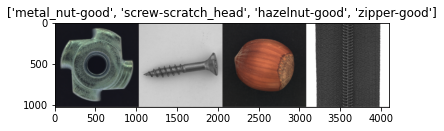

torch.Size([4, 3, 1024, 1024])


In [85]:
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

train_data, train_loader, valid_loader = create_datasets(batch_size=4)


print('train 데이터셋 크기:', len(train_data))

class_names = train_data.classes
print('클래스:', class_names)

def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.43303847, 0.4034577, 0.39415097])
    std = np.array([0.18344551, 0.17549995, 0.1647388])
    input = std * input + mean
    input = np.clip(input, 0, 1)

    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_loader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])
print(inputs.shape)